In [1]:
!bash -c 'source activate tl-detect && conda install -qy -c conda-forge scikit-learn'

Solving environment: ...working... done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
# Visualizations will be shown in the notebook.
%matplotlib inline

In [3]:
UNKNOWN = 4
GREEN = 2
YELLOW = 1
RED = 0

In [189]:
import cv2
import os
import numpy as np
import logging
import pandas as pd

In [5]:
import tensorflow as tf

/opt/conda/envs/tl-detect/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [146]:
# dimensions of our images, we want three times three squares
img_width, img_height = 3*20, 20


def read_img(img_path, dim, colspace = 'BGR'):
    if colspace != 'GRAY':
        img = cv2.imread(img_path)
    else:
        img = cv2.imread(img_path, 0)
    if img is None:
        raise ValueError('Couldn\'t read img: ' + img_path)
    if colspace == 'HSV':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if colspace == 'HLS':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

        
    return cv2.resize(img, dim, interpolation=cv2.INTER_CUBIC)

def read_color(path, color, dim, colspace):
    x = np.stack([read_img(path + f, dim, colspace) for f in os.listdir(path)], axis=0)
    y = np.full(x.shape[0], color)
    p = np.stack([f for f in os.listdir(path)])
    return (x, y, p)

def read_tl_dir(path, dim, colspace, lib='keras'):
    x = []
    y = []
    p = []
    for directory, color in zip(['Red/', 'Yellow/', 'Green/'], [RED, YELLOW, GREEN]): 
        x_img, y_img, f_path = read_color(os.path.join(path, directory), color, dim, colspace)
        x.append(x_img)
        y.append(y_img)
        p.append(f_path)
    
    x = np.concatenate(x)
    y = np.concatenate(y)
    p = np.concatenate(p)
    #x = x.astype('float32')
    return x, y, p
    

def read_train_test_tl(train_path, test_path, dim, colspace, lib='keras'):
    x_train, y_train, p_train = read_tl_dir(train_path, dim, colspace, lib)
    x_test, y_test, p_test = read_tl_dir(test_path, dim, colspace, lib)

    return x_train, y_train, p_train, x_test, y_test, p_test


train_data_dir = '../imgs/training/'
validation_data_dir = '../imgs/validation/'

x_train, y_train, p_train, x_validation, y_validation, p_validation = read_train_test_tl(train_data_dir, 
                                                                                         validation_data_dir, 
                                                                                         dim=(img_height, img_width),
                                                                                         colspace='YSL', lib='tf')

assert x_train.shape != x_validation.shape
assert x_train.shape[1:] == x_validation.shape[1:]

In [147]:
x = np.concatenate([x_train, x_validation])
y = np.concatenate([y_train, y_validation])
p = np.concatenate([p_train, p_validation])

In [148]:
def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    channels = 3
    if (len(X_imgs[0].shape) == 3):
        row, col, _ = X_imgs[0].shape
    else:
        row, col = X_imgs[0].shape
        channels = 1
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    print(row, col)
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        if channels == 3:
            gaussian = np.concatenate((gaussian, gaussian, gaussian), axis=2)           
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype=np.float32)
    return gaussian_noise_imgs

In [149]:
def augment_imgs(X_imgs):
    np.random.seed(seed=42)
    col_mod = add_gaussian_noise(X_imgs)
    return col_mod

def balance_data(X_imgs, label, target_amount=5000):
    np.random.seed(seed=42)
    x_bal = []
    y_bal = []
    for col in [RED, GREEN, YELLOW]:
        aug_idx = np.random.choice(np.where(label==col)[0], target_amount, replace=True)
        x_bal.append(X_imgs[aug_idx])
        y_bal.append(label[aug_idx])

    x_bal = np.concatenate(x_bal)
    y_bal = np.concatenate(y_bal)
    
    return x_bal, y_bal

In [198]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

#X_train, y_train = balance_data(X_train, y_train)
#X_test, y_test = balance_data(X_test, y_test, target_amount=200)
#X_train = augment_imgs(X_train)

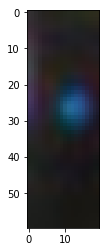

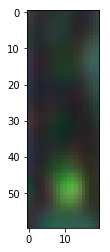

In [199]:
idx = 50
plt.figure(1)
plt.imshow(X_test[50])
plt.figure(2)
plt.imshow(X_test[2])


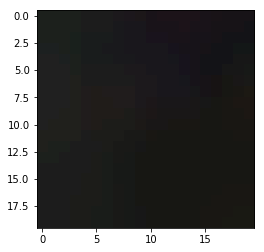

In [200]:
img = X_test[50]
box = 2
img_sqr = img[box * 20 : (box + 1) * 20, :]
img_sqr = cv2.GaussianBlur(img_sqr, (5, 5), 0)
K = 5
Z = img_sqr.reshape((-1,1))
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img_sqr.shape))
plt.imshow(res2)


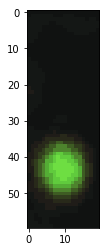

In [201]:
img = X_test[56]
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
ret,label,center = cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
plt.imshow(res2)

In [202]:
box = 0
box1_mean = np.mean(img[box * 20 : ((box + 1) * 20 - 1), :])
box = 1
box2_mean = np.mean(img[box * 20 : ((box + 1) * 20 - 1), :])
box = 2
box3_mean = np.mean(img[box * 20 : ((box + 1) * 20 - 1), :])



In [203]:
def tl_classifier(img):
    highest_mean = 0
    tl_col = UNKNOWN
    for i, col in enumerate([RED, YELLOW, GREEN]):
        box_mean = np.mean(img[i * 20 : ((i + 1) * 20 - 1), :])
        if box_mean > highest_mean:
            highest_mean = box_mean
            tl_col = col
            
    return tl_col

In [209]:
tl_predictions = np.array([tl_classifier(img) for img in x_validation])

In [210]:
pd.crosstab(tl_predictions, y_validation, rownames=['pred'], colnames=['obs'])

obs,0,1,2
pred,,,
0,398,0,0
1,3,150,0
2,0,0,342


In [206]:
np.where(tl_predictions != y_train)

(array([  16,   21,   24,   34,   44,   49,   53,   54,   56,   60,   71,
          82,   83,   88,   95,  117,  130,  142,  153,  159,  166,  175,
         181,  184,  188,  196,  199,  200,  209,  215,  217,  220,  223,
         225,  227,  228,  233,  243,  257,  268,  281,  285,  305,  308,
         323,  326,  337,  342,  349,  354,  360,  375,  384,  387,  392,
         408,  424,  431,  435,  444,  452,  457,  458,  469,  471,  475,
         480,  482,  485,  498,  500,  506,  510,  515,  516,  520,  524,
         534,  537,  541,  554,  564,  565,  568,  570,  574,  583,  596,
         604,  609,  629,  630,  637,  642,  652,  655,  663,  674,  676,
         678,  706,  737,  742,  743,  747,  752,  758,  760,  792,  795,
         797,  802,  804,  805,  806,  808,  809,  821,  825,  828,  860,
         861,  871,  881,  883,  884,  896,  927,  934,  952,  958,  963,
         972,  977,  978,  993,  999, 1001, 1009, 1010, 1032, 1049, 1063,
        1078, 1091, 1100, 1107, 1111, 

0

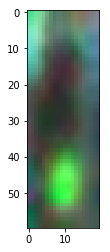

In [207]:
idx = 16
plt.imshow(X_train[idx])
tl_classifier(X_train[idx])

0

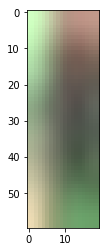

In [208]:
idx = 3807
plt.imshow(X_train[idx])
tl_classifier(X_train[idx])